In [937]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [938]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from category_encoders import *
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.svm import SVR
from scipy import stats
from scipy.stats import norm 
import warnings 
warnings.simplefilter('ignore')

In [939]:
sns.set(rc = {'figure.figsize': (12,8)})
%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 2000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [940]:
train = pd.read_csv('train.csv')

In [941]:
test = pd.read_csv('test.csv')

In [942]:
train = train.set_index('Id')

In [943]:
test = test.set_index('Id')

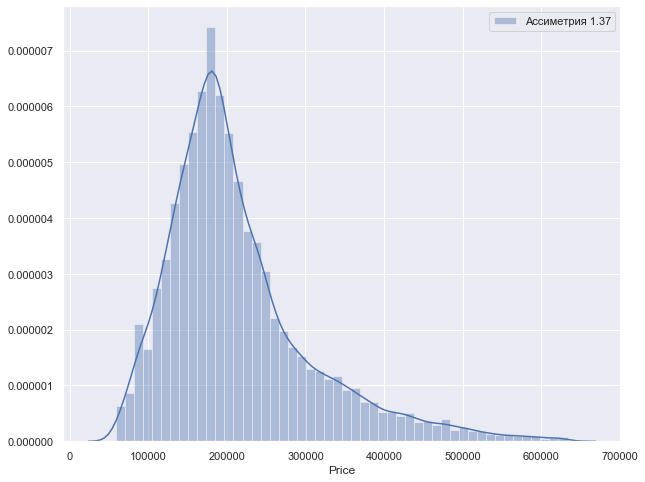

In [944]:
plt.figure(figsize = (10,8))
bar = sns.distplot(train['Price'])
bar.legend([f"Ассиметрия {round(train['Price'].skew(),2)}"])
plt.show()

Обзор

In [945]:
train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000,10000.000,10000.000,7887.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,5202.000,10000.000,10000.000,10000.000
mean,50.401,1.891,56.316,37.200,6.273,8.527,12.609,3990.166,0.119,24.687,5352.157,8.039,1142.904,1.319,4.231,214138.857
std,43.588,0.840,21.059,86.241,28.561,5.241,6.776,200500.261,0.119,17.533,4006.800,23.832,1021.517,1.494,4.806,92872.294
min,0.000,0.000,1.137,0.371,0.000,1.000,0.000,1910.000,0.000,0.000,168.000,0.000,0.000,0.000,0.000,59174.778
25%,20.000,1.000,41.775,22.770,1.000,4.000,9.000,1974.000,0.018,6.000,1564.000,0.000,350.000,0.000,1.000,153872.634
50%,36.000,2.000,52.513,32.781,6.000,7.000,13.000,1977.000,0.075,25.000,5285.000,2.000,900.000,1.000,3.000,192269.645
75%,75.000,2.000,65.901,45.129,9.000,12.000,17.000,2001.000,0.196,36.000,7227.000,5.000,1548.000,2.000,6.000,249135.462
max,209.000,19.000,641.065,7480.592,2014.000,42.000,117.000,20052011.000,0.522,74.000,19083.000,141.000,4849.000,6.000,23.000,633233.467


убереем неверные данные. 

In [946]:
train.loc[train['LifeSquare']>700,'LifeSquare'] = np.nan
train.loc[train['KitchenSquare']>700,'KitchenSquare'] = np.nan
train.loc[train['HouseYear']>2020,'HouseYear'] = np.nan

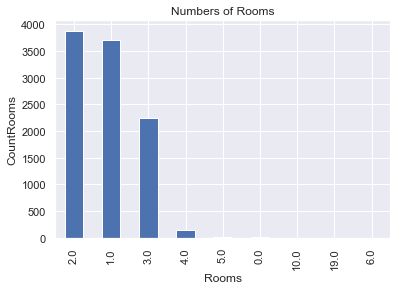

In [947]:
train['Rooms'].value_counts().plot(kind = 'bar')
plt.title('Numbers of Rooms')
plt.xlabel('Rooms')
plt.ylabel('CountRooms')
plt.show()

Жилая + общая

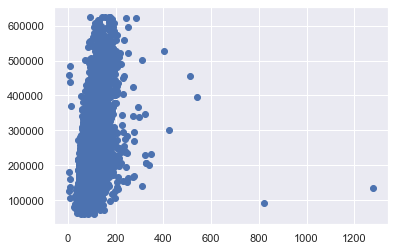

In [948]:
plt.scatter((train['Square']+train['LifeSquare']), train['Price'])

In [949]:
scat_columns = train.select_dtypes(include = [np.number]).columns

Все признаки

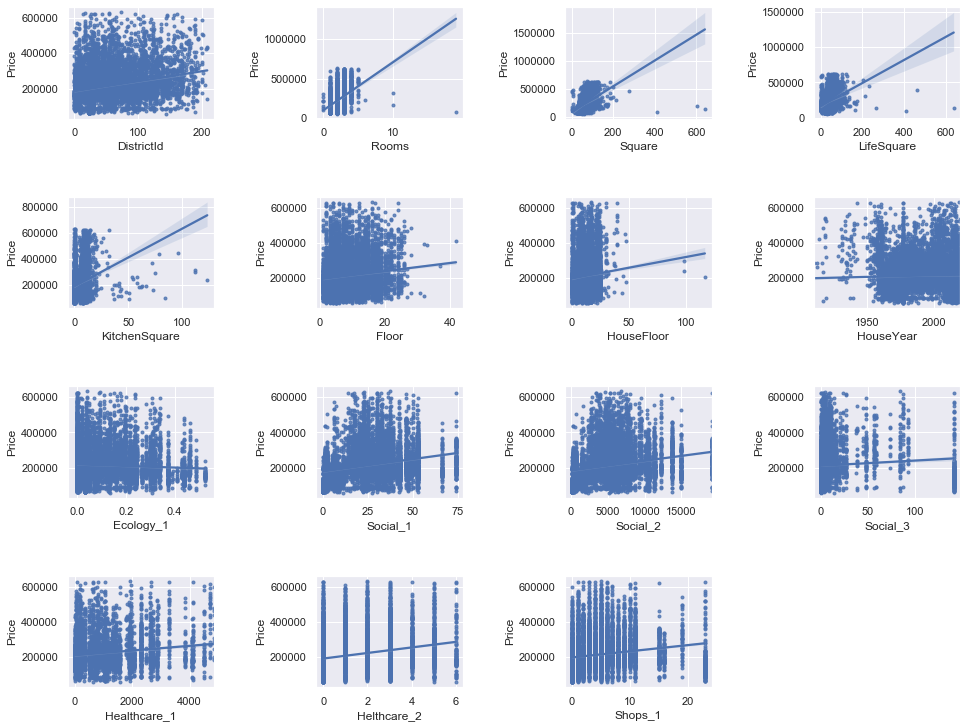

In [950]:

plt.figure(figsize = (16,16))
for i in range(len(scat_columns)-1):
    plt.subplot(5,4,i+1)
    plt.subplots_adjust(hspace = 0.7, wspace = 0.7)
    sns.regplot(data =train, x = scat_columns[i], y = 'Price', marker = '.')

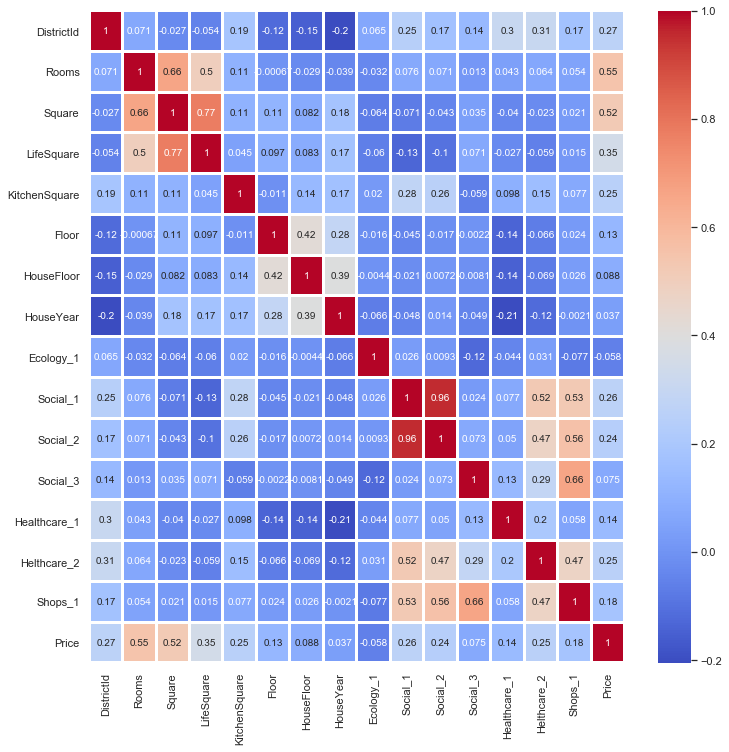

In [951]:
plt.figure(figsize = (12,12))
sns.heatmap(train.corr(), annot = True, cmap = 'coolwarm',linewidth = 2)

In [952]:
df  =pd.concat((train,test))

Объеденим комнаты основная масса с 1 по 3

In [953]:
df.groupby('Rooms').agg({'Square':'median',
                           'Rooms':'count'})

,Square,Rooms
Rooms,,
0.000,78.918,10
1.000,40.327,5474
2.000,55.834,5910
3.000,77.468,3334
4.000,97.358,240
5.000,117.856,25
6.000,110.750,3
10.000,59.964,2
17.000,52.866,1


In [954]:
df.loc[df['Rooms']==0,'Rooms'] = 3
df.loc[df['Rooms']==19,'Rooms'] = 1
df.loc[df['Rooms']==17,'Rooms'] = 2
df.loc[df['Rooms']==10,'Rooms'] = 2
df.loc[df['Rooms']==6,'Rooms'] = 3
df.loc[df['Rooms']==5,'Rooms'] = 3
df.loc[df['Rooms']==4,'Rooms'] = 3

Пропуски

In [955]:
df.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       3155
KitchenSquare       2
Floor               0
HouseFloor          0
HouseYear           2
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     7175
Helthcare_2         0
Shops_1             0
Shops_2             0
Price            5000
dtype: int64

Заполним даныне относительно комнат. 

In [956]:
for i in df['Rooms'].unique():
    mean_valau = df.query('Rooms == @i')['LifeSquare'].median()
    df.loc[(df['Rooms'] == i) & (df['LifeSquare'].isnull()), 'LifeSquare'] = mean_valau

In [957]:
for i in df['Rooms'].unique():
    mean_valau = df.query('Rooms == @i')['KitchenSquare'].median()
    df.loc[(df['Rooms'] == i) & (df['KitchenSquare'].isnull()), 'KitchenSquare'] = mean_valau

In [958]:
df['HouseYear'].fillna(df['HouseYear'].mode(), inplace = True)

In [959]:
df['Healthcare_1'].fillna(df['Healthcare_1'].median(), inplace = True)

Обработка редких категорий

найдем категориальные переменные

In [960]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.000,47.982,29.443,6.000,7,9.000,1969.000,0.089,B,B,33,7976,5,900.000,0,11,B,184966.931
15053,41,3.000,65.684,40.050,8.000,7,9.000,1978.000,0.000,B,B,46,10309,1,240.000,1,16,B,300009.450
4765,53,2.000,44.948,29.198,0.000,8,12.000,1968.000,0.050,B,B,34,7759,0,229.000,1,3,B,220925.909
5809,58,2.000,53.353,52.732,9.000,8,17.000,1977.000,0.438,B,B,23,5735,3,1084.000,0,5,B,175616.227
10783,99,1.000,39.649,23.776,7.000,11,12.000,1976.000,0.012,B,B,35,5776,1,2078.000,2,4,B,150226.532


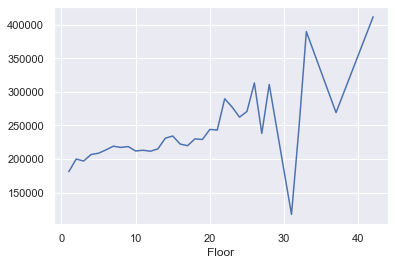

In [961]:
train.groupby('Floor')['Price'].mean().plot()
plt.show()

In [962]:
df.groupby('Floor').agg({'Floor':'count',
                           }).tail(15)

,Floor
Floor,
23,58
24,71
25,53
26,32
27,13
28,4
31,2
32,4
33,2


In [963]:
df.loc[df['Floor']==42,'Floor'] = 22
df.loc[df['Floor']==37,'Floor'] = 24
df.loc[df['Floor']==33,'Floor'] = 22
df.loc[df['Floor']==32,'Floor'] = 21
df.loc[df['Floor']==31,'Floor'] = 1
df.loc[df['Floor']==28,'Floor'] = 22
df.loc[df['Floor']==27,'Floor'] = 20
df.loc[df['Floor']==34,'Floor'] = 21
df.loc[df['Floor']==38,'Floor'] = 22
df.loc[df['Floor']==46,'Floor'] = 22
df.loc[df['Floor']==78,'Floor'] = 24

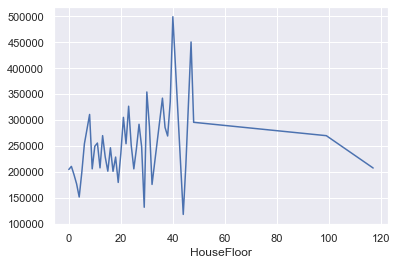

In [964]:
train.groupby('HouseFloor')['Price'].mean().plot()
plt.show()

In [965]:
df.groupby('HouseFloor').agg({'HouseFloor':'count'}).tail()

,HouseFloor
HouseFloor,
45.000,1
47.000,1
48.000,5
99.000,3
117.000,1


In [966]:
bins = [-np.inf, 5, 12, np.inf]
group_names = ['Малоэтажка', 'Средний дома', 'Многоэтажка']
df['HouseFloor_DUM'] = pd.cut(df['HouseFloor'], bins, labels=group_names)

у этажности дома цена не зависит от стоимости. Будет категориальная и заполним обычным заполнением

все дома меньше 6 переводимм в ккатегорию 999 

In [967]:
df.loc[df['HouseFloor'].value_counts()[df['HouseFloor']].values < 10,  
         'HouseFloor'] = 999

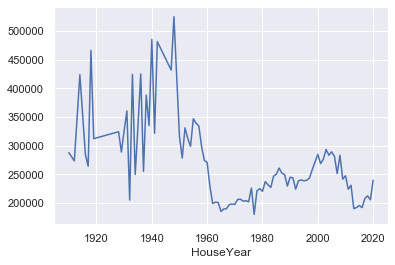

In [968]:
train.groupby('HouseYear')['Price'].mean().plot()
plt.show()

In [969]:
df.groupby('HouseYear').agg({'HouseYear':'count'})

,HouseYear
HouseYear,
1908.000,1
1909.000,1
1910.000,2
1911.000,1
1912.000,3
1914.000,2
1916.000,1
1917.000,4
1918.000,8


дома до 1960 года отправис в отдельную категорию 

In [970]:
df.loc[df['HouseYear']<1960,'HouseYear'] = 1959

In [971]:
df['HouseYear'].fillna(df['HouseYear'].mode()[0],inplace = True)

In [972]:
bins = [-np.inf, 1960, 2000, np.inf]
group_names = ['Old', 'Mid', 'Young']
df['HouseYear_DUM'] = pd.cut(df['HouseYear'], bins, labels=group_names)

Социалка

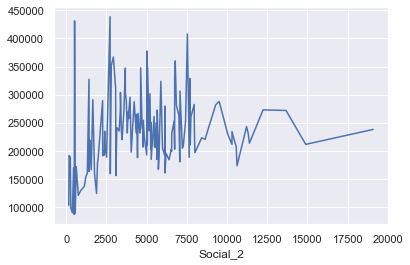

In [973]:
train.groupby('Social_2')['Price'].mean().plot()
plt.show()

In [974]:
df.groupby('Social_2').agg({'Social_2':'count'})

,Social_2
Social_2,
168,282
186,19
264,884
290,16
342,1
362,4
388,90
469,197
475,83


In [975]:
df.loc[df['Social_2'].value_counts()[df['Social_2']].values < 10,  
         'Social_2'] = 999

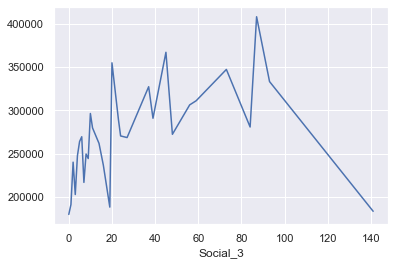

In [976]:
train.groupby('Social_3')['Price'].mean().plot()
plt.show()

In [977]:
df.groupby('Social_3').agg({'Social_3':'count'})

,Social_3
Social_3,
0,4467
1,2757
2,958
3,1676
4,1279
5,592
6,637
7,276
8,247


In [978]:
df.loc[df['Social_3']==141,'Social_3'] = 0
df.loc[df['Social_3']==84,'Social_3'] = 48
df.loc[df['Social_3']==73,'Shops_1'] = 42

Здравоохранение

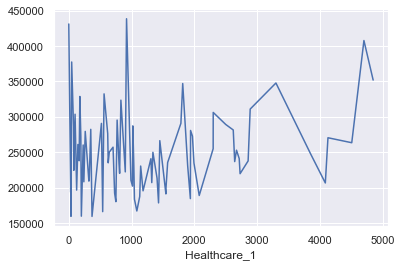

In [979]:
train.groupby('Healthcare_1')['Price'].mean().plot()
plt.show()


In [980]:
df.groupby('Healthcare_1').agg({'Healthcare_1':'count'})

,Healthcare_1
Healthcare_1,
0.000,2
30.000,511
32.000,19
35.000,4
46.000,68
75.000,31
80.000,57
100.000,38
125.000,151


In [981]:
df.loc[df['Healthcare_1'].value_counts()[df['Healthcare_1']].values < 10,  
         'Healthcare_1'] = 30

магазины

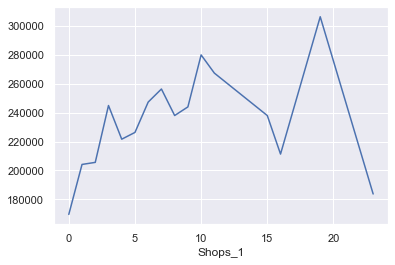

In [982]:
train.groupby('Shops_1')['Price'].mean().plot()
plt.show()

In [983]:
df.groupby('Shops_1').agg({'Shops_1':'count'})

,Shops_1
Shops_1,
0,3466
1,1976
2,1448
3,1079
4,1254
5,1974
6,731
7,442
8,358


In [984]:
df.loc[df['Shops_1']==23,'Shops_1'] = 0
df.loc[df['Shops_1']==16,'Shops_1'] = 5
df.loc[df['Shops_1']==9,'Shops_1'] = 3

Районы 

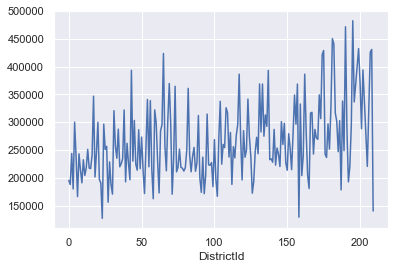

In [985]:
train.groupby('DistrictId')['Price'].mean().plot()
plt.show()


In [986]:
df['DistrictId'].value_counts().tail(10)

210    1
199    1
203    1
211    1
204    1
212    1
117    1
174    1
198    1
207    1
Name: DistrictId, dtype: int64

In [987]:
df.loc[df['DistrictId'].value_counts()[df['DistrictId']].values < 5,  
         'DistrictId'] = 999

Экология

In [988]:
df['Ecology_1'] =round(df['Ecology_1'],2)

In [989]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseFloor_DUM,HouseYear_DUM
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.000,47.982,29.443,6.000,7,9.000,1969.000,0.090,B,B,33,7976,5,900.000,0,11,B,184966.931,Средний дома,Mid
15053,41,3.000,65.684,40.050,8.000,7,9.000,1978.000,0.000,B,B,46,10309,1,240.000,1,5,B,300009.450,Средний дома,Mid
4765,53,2.000,44.948,29.198,0.000,8,12.000,1968.000,0.050,B,B,34,7759,0,229.000,1,3,B,220925.909,Средний дома,Mid
5809,58,2.000,53.353,52.732,9.000,8,17.000,1977.000,0.440,B,B,23,5735,3,1084.000,0,5,B,175616.227,Многоэтажка,Mid
10783,99,1.000,39.649,23.776,7.000,11,12.000,1976.000,0.010,B,B,35,5776,1,2078.000,2,4,B,150226.532,Средний дома,Mid


Переведем площадь в инт и надем одинаковые данные 

In [990]:
for i in ['Square','LifeSquare','KitchenSquare']:
    df[i] = df[i].astype(int)

In [991]:
df.loc[df['Square'] == df['LifeSquare'], 'LifeSquare'] = np.nan

In [992]:
df.loc[df['Square'] == df['KitchenSquare'],'KitchenSquare'] = np.nan

In [993]:
df.loc[df['LifeSquare'] == df['KitchenSquare'], 'KitchenSquare'] = np.nan

In [994]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000,15000.000,15000.000,14686.000,14911.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,10000.000
mean,53.308,1.876,55.860,34.098,5.878,8.536,15.608,1984.997,0.119,24.769,5370.696,4.503,1027.374,1.319,3.442,214138.857
std,68.754,0.768,20.421,17.561,6.879,5.226,55.516,17.838,0.119,17.532,4013.006,10.317,753.338,1.489,3.776,92872.294
min,0.000,1.000,1.000,0.000,0.000,1.000,0.000,1959.000,0.000,0.000,168.000,0.000,30.000,0.000,0.000,59174.778
25%,20.000,1.000,41.000,21.000,1.000,4.000,9.000,1974.000,0.020,6.000,1564.000,0.000,830.000,0.000,0.000,153872.634
50%,37.000,2.000,52.000,32.000,6.000,7.000,12.000,1977.000,0.080,25.000,5285.000,1.000,900.000,1.000,3.000,192269.645
75%,75.000,2.000,66.000,43.000,9.000,12.000,17.000,2001.000,0.200,36.000,7287.000,4.000,990.000,2.000,5.000,249135.462
max,999.000,3.000,641.000,638.000,620.000,26.000,999.000,2020.000,0.520,74.000,19083.000,93.000,4849.000,6.000,42.000,633233.467


Выбросы по кухне. 

In [995]:
df.loc[df['KitchenSquare']>df['Square'],'KitchenSquare'] = np.nan

In [996]:
df.loc[df['KitchenSquare']>df['LifeSquare'],'KitchenSquare'] = np.nan


In [997]:
df.loc[df['KitchenSquare']>10,'KitchenSquare'] = np.nan

In [998]:
df.loc[df['KitchenSquare']>43,'KitchenSquare'] = np.nan

выбросы жилая площадь

In [999]:
df.loc[df['LifeSquare']>df['Square'], 'LifeSquare'] = np.nan

In [1000]:
df.loc[df['LifeSquare']==0, 'LifeSquare'] = np.nan

In [1001]:
df.loc[df['LifeSquare']==1, 'LifeSquare'] = np.nan

In [1002]:
df.loc[df['LifeSquare']<10, 'LifeSquare'] = np.nan

Общая площадь. 

In [1003]:
df.loc[df['Square']<10,'Square'] = np.nan

# Заполнение пропусков 

In [1004]:
df.isnull().sum()

DistrictId           0
Rooms                0
Square              20
LifeSquare        1197
KitchenSquare     1162
Floor                0
HouseFloor           0
HouseYear            0
Ecology_1            0
Ecology_2            0
Ecology_3            0
Social_1             0
Social_2             0
Social_3             0
Healthcare_1         0
Helthcare_2          0
Shops_1              0
Shops_2              0
Price             5000
HouseFloor_DUM       0
HouseYear_DUM        0
dtype: int64

In [1005]:
for value in ['Square','LifeSquare', 'KitchenSquare']:
    for i in df['Rooms'].unique():
        mean_valau = df.query('Rooms == @i')[value].median()
        df.loc[(df['Rooms'] == i) & (df[value].isnull()), value] = mean_valau

In [1006]:
df['HouseYear'].fillna(df['HouseYear'].mode()[0],inplace = True)

# Категориальные признаки

In [1007]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseFloor_DUM,HouseYear_DUM
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.000,47.000,29.000,6.000,7,9.000,1969.000,0.090,B,B,33,7976,5,900.000,0,11,B,184966.931,Средний дома,Mid
15053,41,3.000,65.000,40.000,8.000,7,9.000,1978.000,0.000,B,B,46,10309,1,240.000,1,5,B,300009.450,Средний дома,Mid
4765,53,2.000,44.000,29.000,0.000,8,12.000,1968.000,0.050,B,B,34,7759,0,229.000,1,3,B,220925.909,Средний дома,Mid
5809,58,2.000,53.000,52.000,9.000,8,17.000,1977.000,0.440,B,B,23,5735,3,1084.000,0,5,B,175616.227,Многоэтажка,Mid
10783,99,1.000,39.000,23.000,7.000,11,12.000,1976.000,0.010,B,B,35,5776,1,2078.000,2,4,B,150226.532,Средний дома,Mid


In [1024]:
column_for_dum = ['DistrictId','HouseFloor','Social_2', 'Shops_1','Helthcare_2','Social_3','HouseYear']

In [1025]:
for i in column_for_dum:
    df[i] = df[i].astype('object')

In [1026]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 14038 to 12504
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   DistrictId      15000 non-null  object  
 1   Rooms           15000 non-null  float64 
 2   Square          15000 non-null  float64 
 3   LifeSquare      15000 non-null  float64 
 4   KitchenSquare   15000 non-null  float64 
 5   Floor           15000 non-null  float64 
 6   HouseFloor      15000 non-null  object  
 7   HouseYear       15000 non-null  object  
 8   Ecology_1       15000 non-null  float64 
 9   Ecology_2       15000 non-null  object  
 10  Ecology_3       15000 non-null  object  
 11  Social_1        15000 non-null  float64 
 12  Social_2        15000 non-null  object  
 13  Social_3        15000 non-null  object  
 14  Healthcare_1    15000 non-null  float64 
 15  Helthcare_2     15000 non-null  object  
 16  Shops_1         15000 non-null  object  
 17  Shops_2 

# Логарифмирвоание

In [1027]:
for_log = df.select_dtypes(include = [np.number]).columns

In [1028]:
for_log

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1',
       'Social_1', 'Healthcare_1'],
      dtype='object')

In [1029]:
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,Ecology_1,Social_1,Healthcare_1
count,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000
mean,1.020,3.991,3.468,1.606,2.098,0.107,2.846,6.647
std,0.272,0.311,0.361,0.752,0.578,0.102,1.083,0.913
min,0.693,2.639,2.398,0.000,0.693,0.000,0.000,3.434
25%,0.693,3.738,3.091,0.693,1.609,0.020,1.946,6.723
50%,1.099,3.970,3.497,1.946,2.079,0.077,3.258,6.804
75%,1.099,4.205,3.761,2.197,2.565,0.182,3.611,6.899
max,1.386,6.465,6.460,2.398,3.296,0.419,4.317,8.487


In [1030]:
for i in for_log:
    df[i] = np.log(df[i]+1)

In [1031]:
SalePrice = train['Price']

In [1032]:
SalePrice = np.log(SalePrice+1)

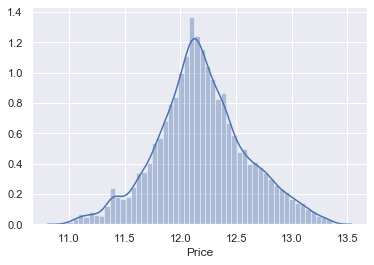

In [1033]:
sns.distplot(SalePrice)
plt.show()

#### наблюдения

In [1034]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 14038 to 12504
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   DistrictId      15000 non-null  object  
 1   Rooms           15000 non-null  float64 
 2   Square          15000 non-null  float64 
 3   LifeSquare      15000 non-null  float64 
 4   KitchenSquare   15000 non-null  float64 
 5   Floor           15000 non-null  float64 
 6   HouseFloor      15000 non-null  object  
 7   HouseYear       15000 non-null  object  
 8   Ecology_1       15000 non-null  float64 
 9   Ecology_2       15000 non-null  object  
 10  Ecology_3       15000 non-null  object  
 11  Social_1        15000 non-null  float64 
 12  Social_2        15000 non-null  object  
 13  Social_3        15000 non-null  object  
 14  Healthcare_1    15000 non-null  float64 
 15  Helthcare_2     15000 non-null  object  
 16  Shops_1         15000 non-null  object  
 17  Shops_2 

In [1035]:
df.drop(['Price'], axis = 1, inplace = True)

KeyError: "['Price'] not found in axis"

In [1036]:
df = pd.get_dummies(df)

In [1037]:
df.shape

(15000, 488)

In [1038]:
scaler = RobustScaler()
scaler.fit(df)
df_new = scaler.transform(df)

In [1039]:
X_train = df_new[:len(train)]
X_test = df_new[len(train):]
y_train = SalePrice

In [1040]:
X_train.shape

(10000, 488)

In [1041]:
X_test.shape

(5000, 488)

# Модель

In [1042]:
def score_model(model, X_train = X_train, y_train = y_train):
    cv = KFold(n_splits = 6, shuffle = True, random_state = 42)
    r2 = make_scorer(r2_score)
    r2_vale_score = cross_val_score(model, X_train, y_train, cv = cv, scoring = r2)
    
    return    f'R2 : {r2_vale_score.mean()}'

In [1043]:
svr = SVR(kernel = 'rbf')

In [1044]:
score_model(svr)

'R2 : 0.7213250729175398'

In [1045]:
svr = SVR(kernel = 'rbf', C = 1, epsilon = 0.01, gamma = 0.1)
svr.fit(X_train, y_train)
y_pred = np.exp(svr.predict(X_test)).round(2)

In [1050]:
preds = pd.DataFrame()
preds['Id'] = test.index
preds['Price'] = y_pred

In [1055]:
preds = preds.set_index('Id')

In [1056]:
preds.to_csv('Mishkin_Kirill_predictions.csv')